# Capacity allocation

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.supply.saver.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)

Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(output_path=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

     Number of Services
RU2                   3
RU3                   7
RU1                   5
RU4                   5
RU5                   5


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = list(supply.lines)
line = infer_line_stations(lines)

Services:  25


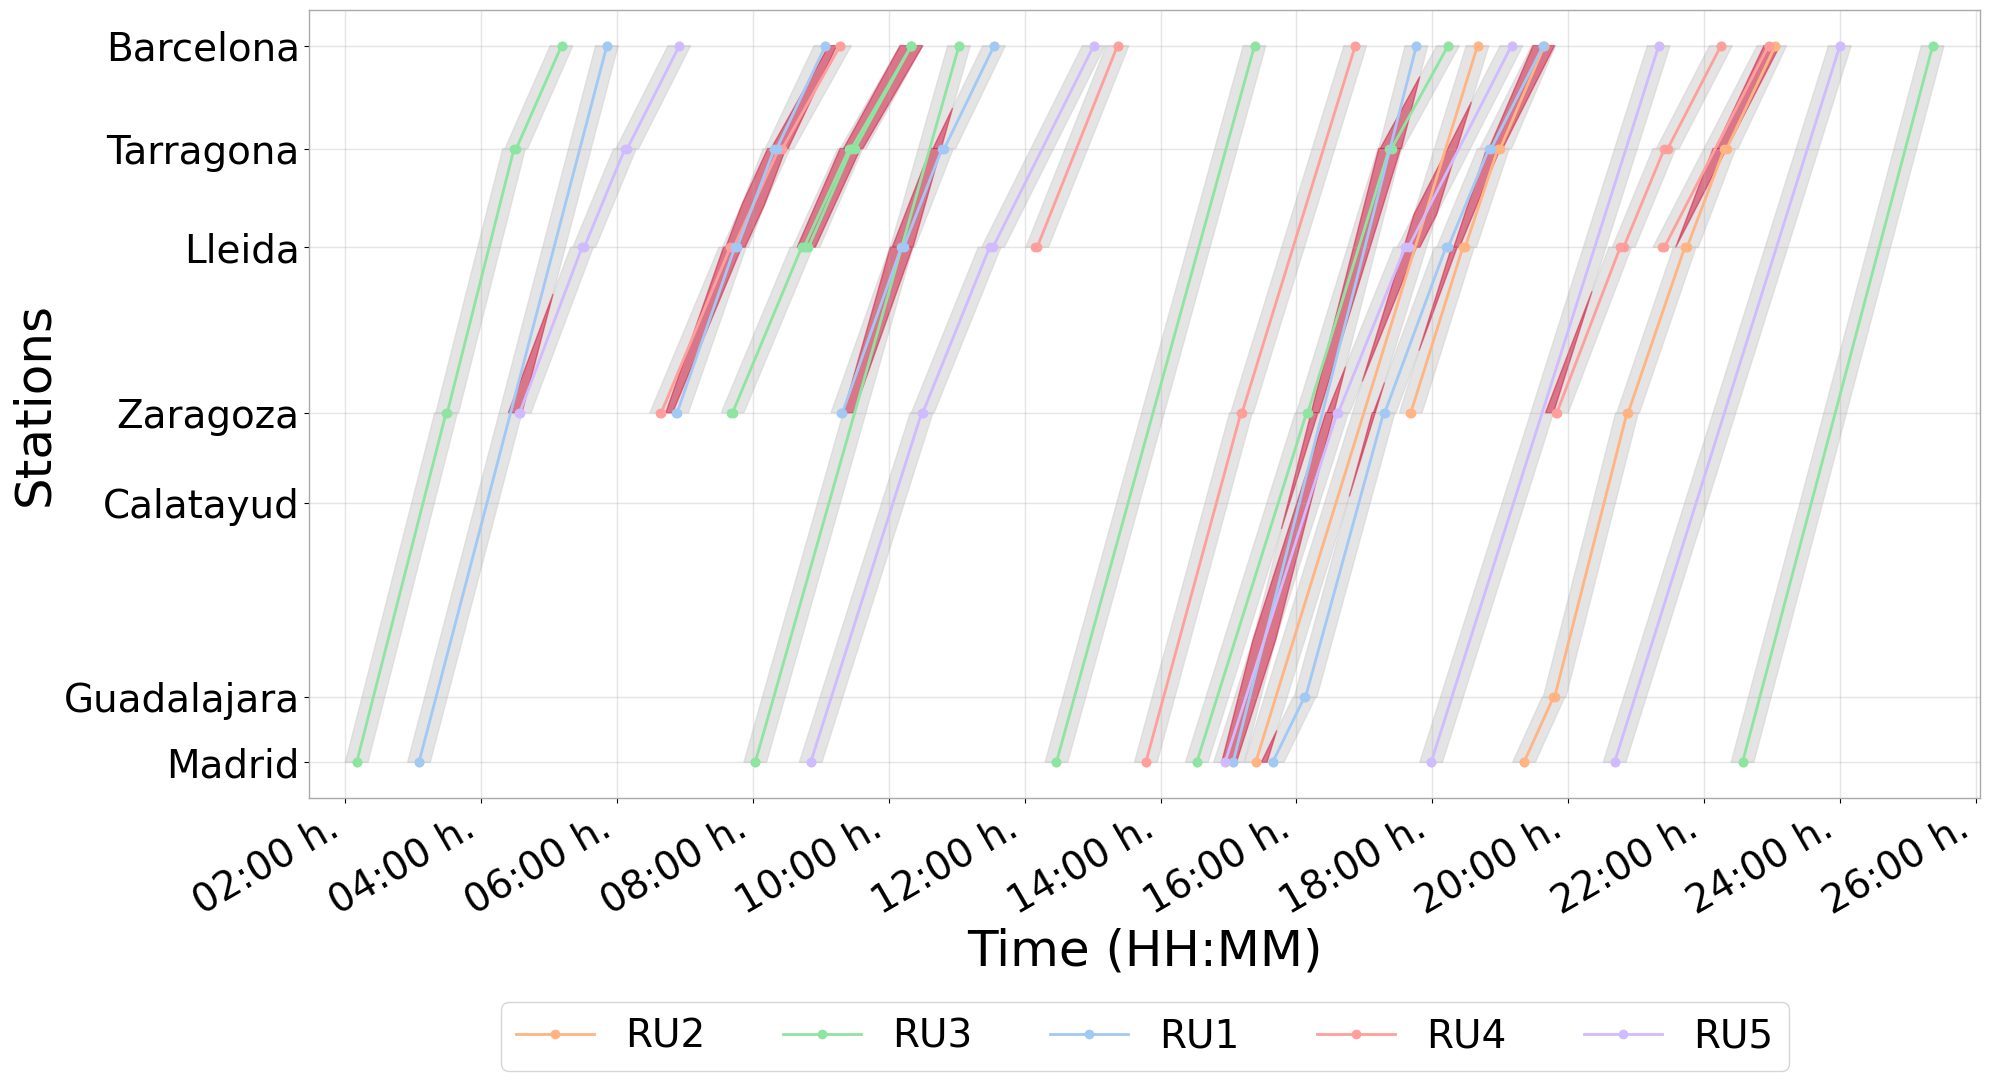

In [6]:
import datetime

date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()
plot_marey_chart(
    supply=supply,
    date=date,
    save_path='../figures/'
)

## 1. Mealpy

In [7]:
from src.timetabling_problem import MPTT

mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behavior=revenue_behavior,
            line=line,
            safe_headway=10)

In [8]:
from mealpy.evolutionary_based import DE, ES, GA
from mealpy.swarm_based import ABC, ACOR, GWO, PSO, WOA
from mealpy.physics_based import SA

mp_algos = {"Genetic Algorithm": GA.BaseGA,
            "Particle Swarm Optimization": PSO.OriginalPSO,
            "Simulated Annealing": SA.OriginalSA,
            "Differential Evolution": DE.OriginalDE,
            "Ant Colony Optimization Continuous (ACOR)": ACOR.OriginalACOR,
            "Covariance Matrix Adaptation Evolution Strategy": ES.CMA_ES,
            "Artificial Bee Colony": ABC.OriginalABC,
            "Grey Wolf Optimizer": GWO.OriginalGWO,
            "Whale Optimization Algorithm": WOA.OriginalWOA,
            "Hybrid Grey Wolf - Whale Optimization Algorithm": GWO.GWO_WOA}

In [ ]:
from mealpy import IntegerVar

runs = 5
epochs = 100
pop_size = 50

seed_initializer = 29

# 0. Problem formulation
lb, ub = zip(*mptt.boundaries.real)

problem = {"obj_func": mptt.objective_function,
           "bounds": IntegerVar(lb=lb,
                              ub=ub),
           "minmax": "max",
           "save_population": True}

# 1. Iter algorithms
df_history = pd.DataFrame()
df_population = pd.DataFrame()

for algo_name, algo in mp_algos.items():

    # Re-initialize seed
    np.random.seed(seed_initializer)

    print(f"Running {algo_name}")
    for r in range(1, runs+1):
        print("\tRun: ", r)

        run_seed = np.random.randint(0, 1000)

        # Run algorithm
        if algo_name == "Simulated Annealing":
            optimizer = algo(epoch=epochs*pop_size)
            optimizer.solve(problem, seed=run_seed)
        else:
            optimizer = algo(epoch=epochs, pop_size=pop_size)
            optimizer.solve(problem, seed=run_seed)

        # Build run history dataframe
        columns = ['Algo', 'Iteration', 'Fitness', 'ExecutionTime', 'Discrete', 'Real',
                   'Diversity', 'Exploitation', 'Exploration']
        run_history = pd.DataFrame(columns=columns)

        # Save optimizer history to dataframe
        for i, data in enumerate(optimizer.history.list_global_best):
            mptt.update_schedule(data.solution)
            run_history.loc[i] = [algo_name,
                                  i,
                                  data.target.fitness,
                                  optimizer.history.list_epoch_time[i],
                                  mptt.get_heuristic_schedule(),
                                  data.solution,
                                  optimizer.history.list_diversity[i],
                                  optimizer.history.list_exploitation[i],
                                  optimizer.history.list_exploration[i]]

        run_history.insert(0, "Run", r)
        df_history = pd.concat([df_history, run_history], axis=0)

        # Population dataframe
        if algo_name == "Simulated Annealing":
            continue

        population_colums = [f'real_{i}' for i in range(pop_size)] + [f'discrete_{i}' for i in range(pop_size)]
        population_colums.insert(0, 'Iteration')
        run_population = pd.DataFrame(columns=population_colums)

        for i, pop_epoch in enumerate(optimizer.history.list_population):
            population_row = [i]
            real = []
            discrete = []
            for individual in pop_epoch:
                mptt.update_schedule(individual.solution)
                real.append(individual.solution)
                discrete.append(mptt.get_heuristic_schedule())

            population_row = [i, *real, *discrete]
            run_population.loc[len(run_population)] = population_row

        run_population.insert(0, "Run", r)
        run_population.insert(1, "Algo", algo_name)
        df_population = pd.concat([df_population, run_population], axis=0)

## 2. Results analysis

In [10]:
reports_path = Path('../reports/mealpy/')

In [ ]:
df_history.to_csv(reports_path / 'df_history_5_seed.csv', sep=";", index=False)

In [ ]:
df_population.to_csv(reports_path / 'df_population_5_seed.csv', sep=";", index=False)

In [11]:
df_history = pd.read_csv(reports_path / 'df_history_5_opti_params.csv', sep=";")
df_population = pd.read_csv(reports_path / 'df_pop_5_opti_fit_top3.csv', sep=";")

In [12]:
df_history

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,2778.469051,0.383515,[False True False True True True True Fal...,[1070. 1109. 1144. 867. 970. 1045. 902. 82...,3.072932,0.000000,100.000000
1,1,Genetic Algorithm,1,2977.993634,0.352017,[False True False True True True True Fal...,[1070. 1109. 1147. 867. 970. 1045. 902. 82...,2.584962,15.879618,84.120382
2,1,Genetic Algorithm,2,3073.698401,0.356388,[False True False True True True True Fal...,[1070. 1109. 1147. 867. 970. 1045. 902. 82...,2.122055,30.943642,69.056358
3,1,Genetic Algorithm,3,3193.633384,0.360162,[False True False True True True True Fal...,[1069. 1109. 1147. 864. 970. 1046. 909. 82...,2.071679,32.582987,67.417013
4,1,Genetic Algorithm,4,3316.756348,0.367846,[False True False True True True True Fal...,[1069. 1117. 1143. 864. 970. 1051. 909. 82...,1.875689,38.960933,61.039067
...,...,...,...,...,...,...,...,...,...,...
194245,5,Hybrid Grey Wolf - Whale Optimization Algorithm,445,2853.852519,0.242790,[False True False True True True True Fal...,[1067.569891 1117.4999 1139.5 861.5 ...,4.825560,16.664042,83.335958
194246,5,Hybrid Grey Wolf - Whale Optimization Algorithm,446,2853.852519,0.240102,[False True False True True True True Fal...,[1067.569891 1117.4999 1139.5 861.5 ...,4.825560,16.664042,83.335958
194247,5,Hybrid Grey Wolf - Whale Optimization Algorithm,447,2853.852519,0.241173,[False True False True True True True Fal...,[1067.569891 1117.4999 1139.5 861.5 ...,4.825560,16.664042,83.335958
194248,5,Hybrid Grey Wolf - Whale Optimization Algorithm,448,2853.852519,0.241031,[False True False True True True True Fal...,[1067.569891 1117.4999 1139.5 861.5 ...,4.825560,16.664042,83.335958


In [13]:
df_population

,Run,Algo,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,real_90,real_91,real_92,real_93,real_94,real_95,real_96,real_97,real_98,real_99
0,1,Genetic Algorithm,0,1306.506198,1880.805779,1552.873792,1768.755804,1613.820165,1507.283674,1582.633885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Genetic Algorithm,1,1692.791509,2381.847007,2106.007880,2432.777387,2977.993634,2116.596572,1501.357637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Genetic Algorithm,2,1868.306199,2276.906491,1784.954098,2322.447220,2119.893318,2925.525707,2809.920079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Genetic Algorithm,3,2174.424896,3156.290969,2822.749008,2751.373340,1987.574101,2287.023335,2553.184708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Genetic Algorithm,4,2341.838848,3150.838056,3160.135616,2428.513490,3215.857806,2927.780946,2594.653704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,5,Differential Evolution,295,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,...,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368
6496,5,Differential Evolution,296,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,...,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368
6497,5,Differential Evolution,297,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,...,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368
6498,5,Differential Evolution,298,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,...,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368,4099.897368


In [14]:
columns_to_transform = df_history.filter(like="Real").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,2778.469051,0.383515,[False True False True True True True Fal...,"[1070, 1109, 1144, 867, 970, 1045, 902, 822, 9...",3.072932,0.000000,100.000000
1,1,Genetic Algorithm,1,2977.993634,0.352017,[False True False True True True True Fal...,"[1070, 1109, 1147, 867, 970, 1045, 902, 822, 9...",2.584962,15.879618,84.120382
2,1,Genetic Algorithm,2,3073.698401,0.356388,[False True False True True True True Fal...,"[1070, 1109, 1147, 867, 970, 1045, 902, 822, 9...",2.122055,30.943642,69.056358
3,1,Genetic Algorithm,3,3193.633384,0.360162,[False True False True True True True Fal...,"[1069, 1109, 1147, 864, 970, 1046, 909, 827, 9...",2.071679,32.582987,67.417013
4,1,Genetic Algorithm,4,3316.756348,0.367846,[False True False True True True True Fal...,"[1069, 1117, 1143, 864, 970, 1051, 909, 827, 9...",1.875689,38.960933,61.039067


In [15]:
columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,2778.469051,0.383515,"[False, True, False, True, True, True, True, F...","[1070, 1109, 1144, 867, 970, 1045, 902, 822, 9...",3.072932,0.000000,100.000000
1,1,Genetic Algorithm,1,2977.993634,0.352017,"[False, True, False, True, True, True, True, F...","[1070, 1109, 1147, 867, 970, 1045, 902, 822, 9...",2.584962,15.879618,84.120382
2,1,Genetic Algorithm,2,3073.698401,0.356388,"[False, True, False, True, True, True, True, F...","[1070, 1109, 1147, 867, 970, 1045, 902, 822, 9...",2.122055,30.943642,69.056358
3,1,Genetic Algorithm,3,3193.633384,0.360162,"[False, True, False, True, True, True, True, F...","[1069, 1109, 1147, 864, 970, 1046, 909, 827, 9...",2.071679,32.582987,67.417013
4,1,Genetic Algorithm,4,3316.756348,0.367846,"[False, True, False, True, True, True, True, F...","[1069, 1117, 1143, 864, 970, 1051, 909, 827, 9...",1.875689,38.960933,61.039067


In [16]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

TypeError: 'float' object is not subscriptable

In [16]:
from src.timetabling_problem import MPTT

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behavior=revenue_behavior,
            line=line,
            safe_headway=10)

top_3_algos = ("Genetic Algorithm",
               "Particle Swarm Optimization",
               "Ant Colony Optimization Continuous (ACOR)")

# Create dataframe with fitness values for each individual of the population
df_pop = df_population[df_population['Algo'].isin(top_3_algos)]

set_filtered_algos = set(df_pop["Algo"])
print(f"Filtered algos: {set_filtered_algos}")

df_pop = df_pop.replace(r'\n', ' ', regex=True)

# Drop unnecessary columns
df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

# Function to compute fitness
def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

# Iterate through the dataframe and apply the function with progress feedback
real_columns = df_pop.columns[df_pop.columns.str.contains('real_')]
previous_run, previous_algo = None, None

for index, row in df_pop.iterrows():
    current_run = row['Run']
    current_algo = row['Algo']

    # Print message if there's a change in 'Run' or 'Algo'
    if current_run != previous_run or current_algo != previous_algo:
        print(f"Processing new combination: Run = {current_run}, Algo = {current_algo}")
        previous_run, previous_algo = current_run, current_algo

    # Apply the fitness function to the real columns
    df_pop.loc[index, real_columns] = row[real_columns].map(fitness_from_real)

print("Processing completed.")
df_pop

Filtered algos: {'Particle Swarm Optimization', 'Genetic Algorithm', 'Ant Colony Optimization Continuous (ACOR)'}
Processing new combination: Run = 1, Algo = Genetic Algorithm
Processing new combination: Run = 2, Algo = Genetic Algorithm
Processing new combination: Run = 3, Algo = Genetic Algorithm
Processing new combination: Run = 4, Algo = Genetic Algorithm
Processing new combination: Run = 5, Algo = Genetic Algorithm
Processing new combination: Run = 1, Algo = Particle Swarm Optimization
Processing new combination: Run = 2, Algo = Particle Swarm Optimization
Processing new combination: Run = 3, Algo = Particle Swarm Optimization
Processing new combination: Run = 4, Algo = Particle Swarm Optimization
Processing new combination: Run = 5, Algo = Particle Swarm Optimization
Processing new combination: Run = 1, Algo = Ant Colony Optimization Continuous (ACOR)
Processing new combination: Run = 2, Algo = Ant Colony Optimization Continuous (ACOR)
Processing new combination: Run = 3, Algo = 

,Run,Algo,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,real_40,real_41,real_42,real_43,real_44,real_45,real_46,real_47,real_48,real_49
0,1,Genetic Algorithm,0,2588.002335,1858.189197,2000.553359,2463.410903,2030.282237,2283.407164,1540.434116,...,2759.522962,2504.703977,2181.093279,1617.424024,2572.30504,2431.397136,1488.995372,2035.559468,2391.548411,1717.45466
1,1,Genetic Algorithm,1,2380.65992,2101.493389,2449.10986,2617.823693,2410.737974,2481.435988,2179.852781,...,1652.766646,2006.141041,1857.450615,2586.962673,2406.699764,2189.497368,2120.799587,2477.939556,2164.964306,1540.434116
2,1,Genetic Algorithm,2,3010.480203,2586.705424,2657.388621,2224.785803,2481.506205,2407.031362,2110.584488,...,1857.450615,2724.931637,2249.470925,2115.714497,2470.774405,3146.862792,2598.06828,2883.161221,2635.641886,2493.955653
3,1,Genetic Algorithm,3,3008.308458,2991.442126,2492.432152,2477.939556,2464.282535,3413.164794,2785.988829,...,2745.75229,2496.249827,2936.309823,3468.686089,2365.140659,2190.332853,2166.256011,2793.616488,2711.700025,2305.560528
4,1,Genetic Algorithm,4,2679.059398,2789.351438,2807.657668,2957.968639,3283.534466,2651.684416,2684.843884,...,2798.942599,2854.438632,3478.384011,2880.375957,2449.759402,3194.973076,2602.655668,2766.267129,2215.254346,2641.967061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,5,Ant Colony Optimization Continuous (ACOR),95,3681.923954,3246.189441,2545.946855,2558.35961,2834.668036,2831.263256,2684.378544,...,2714.981334,3351.077424,2432.343971,3257.0257,3316.85323,2953.205028,2451.608931,2364.193619,2743.069144,3374.858235
1996,5,Ant Colony Optimization Continuous (ACOR),96,3681.923954,3246.189441,2545.946855,2558.35961,2834.668036,2831.263256,2684.378544,...,2352.084392,2688.88801,2714.981334,3351.077424,2432.343971,3257.0257,3316.85323,2953.205028,2451.608931,2364.193619
1997,5,Ant Colony Optimization Continuous (ACOR),97,3681.923954,3246.189441,2964.51954,2545.946855,2558.35961,2834.668036,2831.263256,...,2603.796025,2623.611536,2352.084392,2688.88801,2408.515878,2714.981334,3351.077424,2432.343971,3257.0257,3316.85323
1998,5,Ant Colony Optimization Continuous (ACOR),98,3681.923954,3246.189441,2964.51954,2545.946855,2558.35961,2834.668036,2831.263256,...,2873.930606,2202.928268,2603.796025,2623.611536,2352.084392,2688.88801,2408.515878,2714.981334,3351.077424,2432.343971


In [ ]:
# Save df_pop
df_pop.to_csv(reports_path / 'df_pop_5_seed_fit_top3.csv', sep=";", index=False)

In [18]:
df_pop = df_population

In [19]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    algo = row[1]['Algo']

    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Algorithm': algo, 'Individual': f'ID_{individual}'})

df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,Algorithm,Individual
0,1,0,1306.506198,Genetic Algorithm,ID_real_0
1,1,0,1880.805779,Genetic Algorithm,ID_real_1
2,1,0,1552.873792,Genetic Algorithm,ID_real_2
3,1,0,1768.755804,Genetic Algorithm,ID_real_3
4,1,0,1613.820165,Genetic Algorithm,ID_real_4
...,...,...,...,...,...
649995,5,299,4099.897368,Differential Evolution,ID_real_95
649996,5,299,4099.897368,Differential Evolution,ID_real_96
649997,5,299,4099.897368,Differential Evolution,ID_real_97
649998,5,299,4099.897368,Differential Evolution,ID_real_98


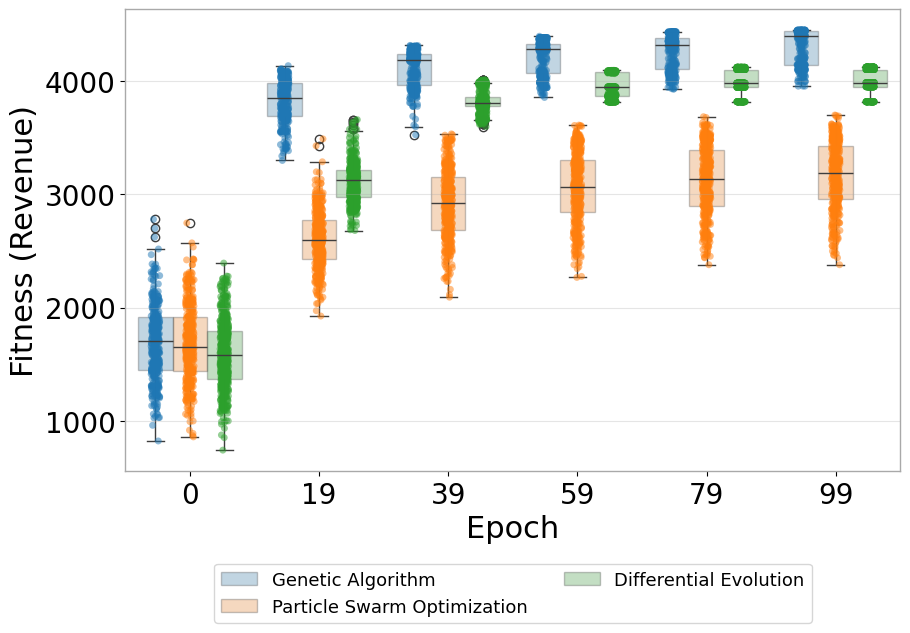

In [23]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 19, 39, 59, 79, 99])]

sns_box_plot(
    df=df_boxplot_filtered,
    x_data='Iteration',
    y_data='Fitness',
    hue='Algorithm',
    title="Scattered Boxplot of Population for Top 3 Algorithms",
    x_label="Epoch",
    y_label="Fitness (Revenue)",
    save_path=Path('../reports/mealpy/scattered_boxplot_top_3_25_opti_new.pdf')
)

In [22]:
# Table with results by run

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behavior,
                         line=line,
                         safe_headway=10)

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Algorithm', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('Algo')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])

            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1

        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"
        row_data =  [algo_group[0], run, revenue, execution_time,
                     scheduled_trains, np.round(delta_dt, 2), np.round(delta_tt, 2), *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

,Algorithm,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU4,RU1,RU2,RU3,RU5
23,Genetic Algorithm,4,4457.33,174.27,19,27.0,19.0,33.33 %,71.43 %,80.0 %,80.0 %,100.0 %
20,Genetic Algorithm,1,4455.60,176.12,18,18.0,7.0,33.33 %,71.43 %,40.0 %,100.0 %,100.0 %
22,Genetic Algorithm,3,4448.94,174.29,18,18.0,11.0,33.33 %,71.43 %,60.0 %,80.0 %,100.0 %
24,Genetic Algorithm,5,4448.12,174.40,18,17.0,9.0,33.33 %,71.43 %,40.0 %,100.0 %,100.0 %
21,Genetic Algorithm,2,4448.12,176.62,18,17.0,9.0,33.33 %,71.43 %,40.0 %,100.0 %,100.0 %
3,Ant Colony Optimization Continuous (ACOR),4,4351.49,76.36,18,54.0,44.0,33.33 %,71.43 %,40.0 %,100.0 %,100.0 %
2,Ant Colony Optimization Continuous (ACOR),3,4335.49,76.25,17,54.0,27.0,33.33 %,71.43 %,40.0 %,100.0 %,80.0 %
4,Ant Colony Optimization Continuous (ACOR),5,4327.14,76.25,18,29.0,39.0,33.33 %,71.43 %,40.0 %,100.0 %,100.0 %
0,Ant Colony Optimization Continuous (ACOR),1,4211.83,74.81,18,46.0,67.0,33.33 %,71.43 %,40.0 %,100.0 %,100.0 %
15,Differential Evolution,1,4122.87,151.10,17,34.0,62.0,33.33 %,71.43 %,60.0 %,60.0 %,100.0 %


In [24]:
summary_df.to_latex()

'\\begin{tabular}{llrrrrrrlllll}\n\\toprule\n & Algorithm & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU4 & RU1 & RU2 & RU3 & RU5 \\\\\n\\midrule\n23 & Genetic Algorithm & 4 & 4457.330000 & 174.270000 & 19 & 27.000000 & 19.000000 & 33.33 % & 71.43 % & 80.0 % & 80.0 % & 100.0 % \\\\\n20 & Genetic Algorithm & 1 & 4455.600000 & 176.120000 & 18 & 18.000000 & 7.000000 & 33.33 % & 71.43 % & 40.0 % & 100.0 % & 100.0 % \\\\\n22 & Genetic Algorithm & 3 & 4448.940000 & 174.290000 & 18 & 18.000000 & 11.000000 & 33.33 % & 71.43 % & 60.0 % & 80.0 % & 100.0 % \\\\\n24 & Genetic Algorithm & 5 & 4448.120000 & 174.400000 & 18 & 17.000000 & 9.000000 & 33.33 % & 71.43 % & 40.0 % & 100.0 % & 100.0 % \\\\\n21 & Genetic Algorithm & 2 & 4448.120000 & 176.620000 & 18 & 17.000000 & 9.000000 & 33.33 % & 71.43 % & 40.0 % & 100.0 % & 100.0 % \\\\\n3 & Ant Colony Optimization Continuous (ACOR) & 4 & 4351.490000 & 76.360000 & 18 & 54.000000 & 44.000000 & 33.33 % & 

In [25]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')

        print(f"Global {algo_group[0]} status:")

        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')

        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')

        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')

        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()

get_global_status(df_history)

Global Ant Colony Optimization Continuous (ACOR) status:
	Total execution time: 0.7586 s.
	Execution Time (by run) - Mean: 0.1517 s. - Std: 0.0028 s.
	Revenue - Mean: 4222.1675 - Std: 196.4983
	Scheduled Trains - Mean: 18.0 - Std: 1.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Artificial Bee Colony status:
	Total execution time: 2.946 s.
	Execution Time (by run) - Mean: 0.5892 s. - Std: 0.0097 s.
	Revenue - Mean: 3684.7437 - Std: 60.3932
	Scheduled Trains - Mean: 17.0 - Std: 1.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Covariance Matrix Adaptation Evolution Strategy status:
	Total execution time: 4.2014 s.
	Execution Time (by run) - Mean: 0.8403 s. - Std: 0.0645 s.
	Revenue - Mean: 3201.5653 - Std: 111.5301
	Scheduled Trains - Mean: 15.0 - Std: 1.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Differential Evolution status:
	Total execution time: 2.5187 s.


In [26]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')

    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')

        run_times = run_grouped_df['ExecutionTime'].sum()

        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)

        result = {
            'Algorithm': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }

        results.append(result)

    results_df = pd.DataFrame(results)

    # Short by column 'Mean Fitness'
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

,Algorithm,Mean Execution Time (seconds),Std Execution Time (seconds),Mean Fitness (revenue),Std Fitness (revenue),Mean Scheduled Trains,Std Scheduled Trains
0,Genetic Algorithm,175.14,1.14,4451.62,4.48,18,0
1,Ant Colony Optimization Continuous (ACOR),75.59,0.98,4222.17,196.50,18,1
2,Differential Evolution,150.23,3.11,3994.18,124.25,17,1
3,Particle Swarm Optimization,196.39,1.01,3818.86,165.93,16,1
4,Grey Wolf Optimizer,241.71,0.36,3713.27,104.76,17,1
5,Artificial Bee Colony,265.44,0.41,3684.74,60.39,17,1
6,Whale Optimization Algorithm,156.03,0.15,3561.12,35.53,15,0
7,Covariance Matrix Adaptation Evolution Strategy,201.04,11.60,3201.57,111.53,15,1
8,Simulated Annealing,174.94,2.22,3057.73,284.10,16,0
9,Hybrid Grey Wolf - Whale Optimization Algorithm,108.83,0.31,2916.05,60.51,16,0


In [27]:
results_df.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n & Algorithm & Mean Execution Time (seconds) & Std Execution Time (seconds) & Mean Fitness (revenue) & Std Fitness (revenue) & Mean Scheduled Trains & Std Scheduled Trains \\\\\n\\midrule\n0 & Genetic Algorithm & 175.140000 & 1.140000 & 4451.620000 & 4.480000 & 18 & 0 \\\\\n1 & Ant Colony Optimization Continuous (ACOR) & 75.590000 & 0.980000 & 4222.170000 & 196.500000 & 18 & 1 \\\\\n2 & Differential Evolution & 150.230000 & 3.110000 & 3994.180000 & 124.250000 & 17 & 1 \\\\\n3 & Particle Swarm Optimization & 196.390000 & 1.010000 & 3818.860000 & 165.930000 & 16 & 1 \\\\\n4 & Grey Wolf Optimizer & 241.710000 & 0.360000 & 3713.270000 & 104.760000 & 17 & 1 \\\\\n5 & Artificial Bee Colony & 265.440000 & 0.410000 & 3684.740000 & 60.390000 & 17 & 1 \\\\\n6 & Whale Optimization Algorithm & 156.030000 & 0.150000 & 3561.120000 & 35.530000 & 15 & 0 \\\\\n7 & Covariance Matrix Adaptation Evolution Strategy & 201.040000 & 11.600000 & 3201.570000 & 111.530000 

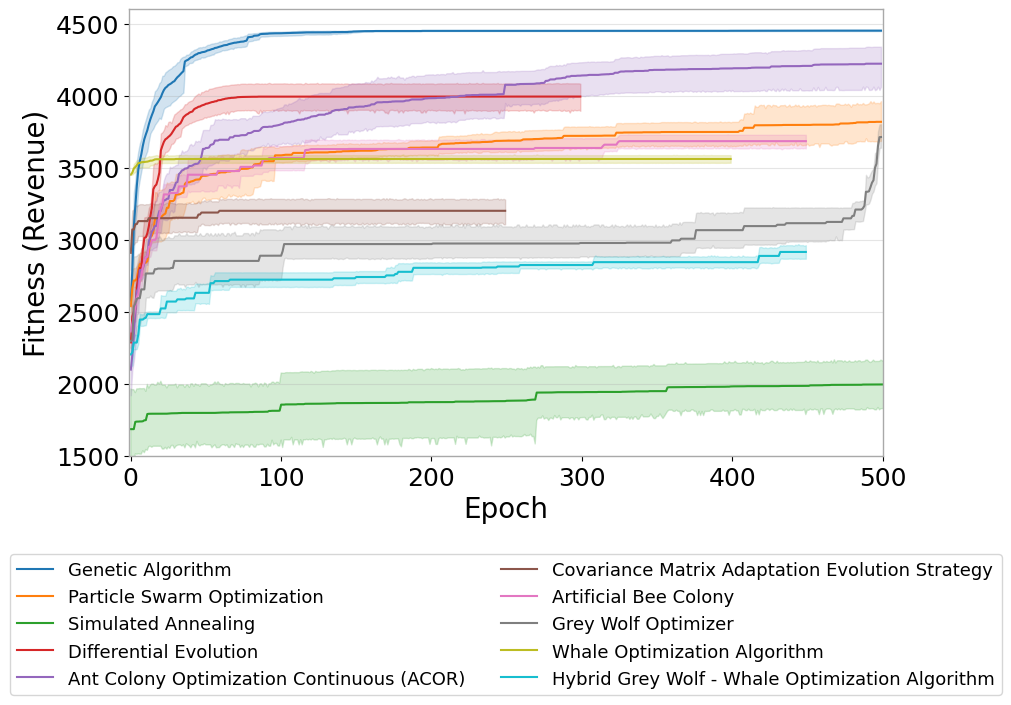

In [32]:
sns_line_plot(
    df=df_history,
    x_data="Iteration",
    y_data="Fitness",
    hue="Algo",
    title="Convergence curves",
    x_label="Epoch",
    y_label="Fitness (Revenue)",
    x_limit=(-1, 500),
    y_limit=(1500, 4600),
    save_path=Path('../reports/mealpy/mealpy_convergence_5_opti.pdf'),
    fig_size=(10, 9)
)

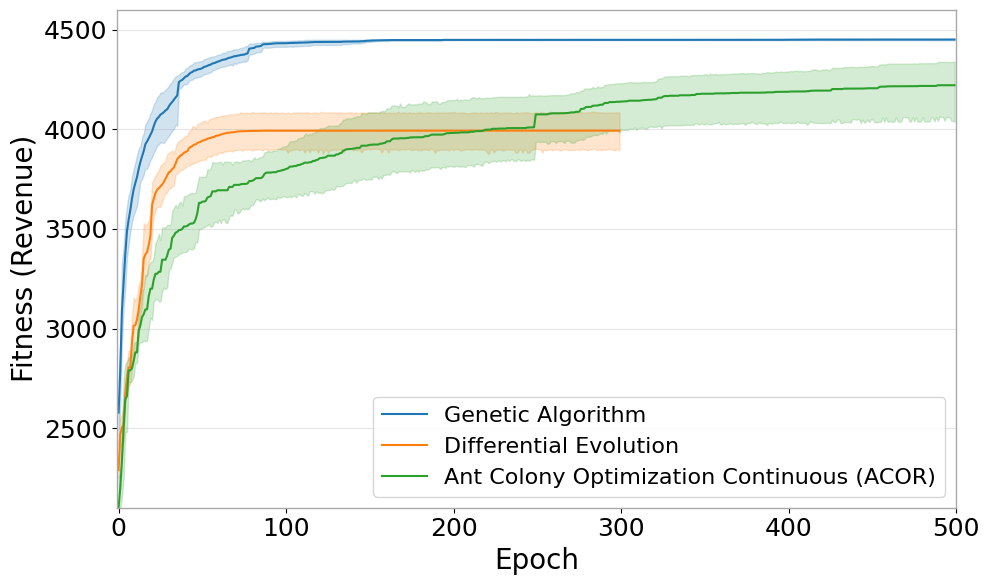

In [31]:
top_3_algos = (
    "Genetic Algorithm",
    "Differential Evolution",
    "Ant Colony Optimization Continuous (ACOR)"
)

# Create dataframe with fitness values for each individual of the population
df_history_top_3 = df_history[df_history['Algo'].isin(top_3_algos)]

sns_line_plot(
    df=df_history_top_3,
    x_data="Iteration",
    y_data="Fitness",
    hue="Algo",
    title="Convergence curves for Top 3 Algorithms",
    x_label="Epoch",
    y_label="Fitness (Revenue)",
    x_limit=(-1, 500),
    y_limit=(2100,4600),
    save_path=Path('../reports/mealpy/mealpy_convergence_5_opti_top_3.pdf'),
    legend_type="inside",
    fig_size=(10, 7)
)

In [26]:
df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,2459.878405,0.246457,"[False, True, False, True, True, True, True, F...","[1070, 1114, 1143, 867, 970, 1046, 902, 827, 9...",3.209825,0.000000,100.000000
1,1,Genetic Algorithm,1,2460.308339,0.243454,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1142, 864, 970, 1045, 898, 822, 9...",2.827368,11.915173,88.084827
2,1,Genetic Algorithm,2,2574.487027,0.243266,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1142, 872, 970, 1045, 902, 822, 9...",2.692281,16.123743,83.876257
3,1,Genetic Algorithm,3,2926.528932,0.239713,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1143, 872, 970, 1045, 902, 822, 9...",2.463509,23.250984,76.749016
4,1,Genetic Algorithm,4,3015.854710,0.239389,"[False, True, False, True, True, False, True, ...","[1061, 1109, 1144, 866, 971, 1046, 904, 827, 9...",2.223509,30.728028,69.271972


In [41]:
N = 50  # Número de saltos que quieres aplicar

algo_1_vals = df_history[df_history['Algo'] == 'Simulated Annealing'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()

algo_df = df_history[df_history['Algo'] == 'Genetic Algorithm']

algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()

print(len(algo_vals))
algo_df = df_history[df_history['Algo'] == 'Simulated Annealing']

N = 50
algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()

print(len(algo_vals))

500
700


In [42]:
# Confusion Matrix stadistical differences

from scipy import stats

def get_epoch_last_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(list).sum()
    else:
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()
    return algo_vals

def get_epoch_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()
    else:
        algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()
    return algo_vals

matrix_wilcoxon = []
matrix_p_values = []
for algo_name, algo in mp_algos.items():
    row_w = []
    row_p = []
    for algo_name_2, algo_2 in mp_algos.items():
        if algo_name == algo_name_2:
            row_w.append(np.nan)
            row_p.append(np.nan)
            continue

        algo_1_vals = get_epoch_best_fitness(df_history, algo_name)
        algo_2_vals = get_epoch_best_fitness(df_history, algo_name_2)
        stat, p_value = stats.wilcoxon(algo_1_vals, algo_2_vals)
        row_w.append(round(stat))
        row_p.append(round(p_value, 3))
    matrix_wilcoxon.append(row_w)
    matrix_p_values.append(row_p)

ValueError: The samples x and y must have the same length.

In [33]:
print("Wilcoxon Matrix")
df_wilcoxon = pd.DataFrame(matrix_wilcoxon, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_wilcoxon)

Wilcoxon Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      3.0   
Covariance Matrix Adaptation Evolution Strategy               39.0   
Artificial Bee Colony                                          1.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                 239.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                        0.0   
Particle Swarm Optimization                          

In [34]:
print("P-Values Matrix")
df_p_values = pd.DataFrame(matrix_p_values, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_p_values)

P-Values Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      0.0   
Covariance Matrix Adaptation Evolution Strategy                0.0   
Artificial Bee Colony                                          0.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                   0.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                      0.000   
Particle Swarm Optimization                          

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_wilcoxon, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_wilcoxon.columns, rotation=30, ha='right')
plt.yticks(range(10), df_wilcoxon.index)
plt.title('Confusion Matrix - Wilcoxon Statistic', fontweight='bold', fontsize=18)

for i in range(df_wilcoxon.shape[0]):
    for j in range(df_wilcoxon.shape[1]):
        value = df_wilcoxon.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{int(value)}"
            text_color = 'black' if value > 50000 else 'white'

        plt.text(j, i, display_value, ha='center', va='center', color=text_color)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/wilcoxon_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
# Visualización con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(df_p_values, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_p_values.columns, rotation=30, ha='right')
plt.yticks(range(10), df_p_values.index)
plt.title('Confusion Matrix - P-values', fontweight='bold', fontsize=18)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.4 else 'white'

        plt.text(j, i, display_value, ha='center', va='center', color=text_color)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 10))
plt.imshow(df_p_values, cmap='seismic', interpolation='nearest')
plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), df_p_values.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(range(df_p_values.shape[0]), df_p_values.index, fontsize=10)
plt.title('Matrix of P-values Between Algorithms', fontweight='bold', fontsize=20)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.3 and value < 0.7 else 'white'

        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=8)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

In [33]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

cmap = colors.ListedColormap(['#b3e5b3', '#ffb3b3'])
bounds = [0, 0.05, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

names = ["GA", "PSO", "SA", "DE", "ACOR", "CMA-ES", "ABC", "GWO", "WOA", "GWO-WOA"]
plt.figure(figsize=(10, 10))
plt.imshow(df_p_values, cmap=cmap, norm=norm, interpolation='nearest')
# plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), names, rotation=30, ha='right', fontsize=20)
plt.yticks(range(df_p_values.shape[0]), names, rotation=30, fontsize=20)
#plt.title('Algorithm Pairwise Comparison: p-Values', fontweight='bold', fontsize=30)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black'

        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=18)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved_opti_df_history.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

NameError: name 'df_p_values' is not defined

<Figure size 1000x1000 with 0 Axes>

In [44]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 2
iteration = 99

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

Real: [1063 1115 1142  872  970 1044  914  826  912 1354  731  130  210  271
  473  531  630  693  933  749  183  392  466  507  939  968 1038 1094
 1132 1161 1188 1253 1310 1345  413  467  502  274  332  370  537  573
 1071 1190 1249 1288  559  613  650 1241  462  525  568 1276  896  998
 1061], Discrete: [False  True False  True  True  True  True False  True False  True False
 False  True  True  True  True False  True  True  True  True  True  True
  True]


In [45]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behavior,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_opti'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(output_path=f'{supply_save_path}/{tt_file_name}.yml')

../configs/mealpy/ supply_config_opti


In [47]:
final_supply = Supply.from_yaml(f'{supply_save_path}/{tt_file_name}.yml')

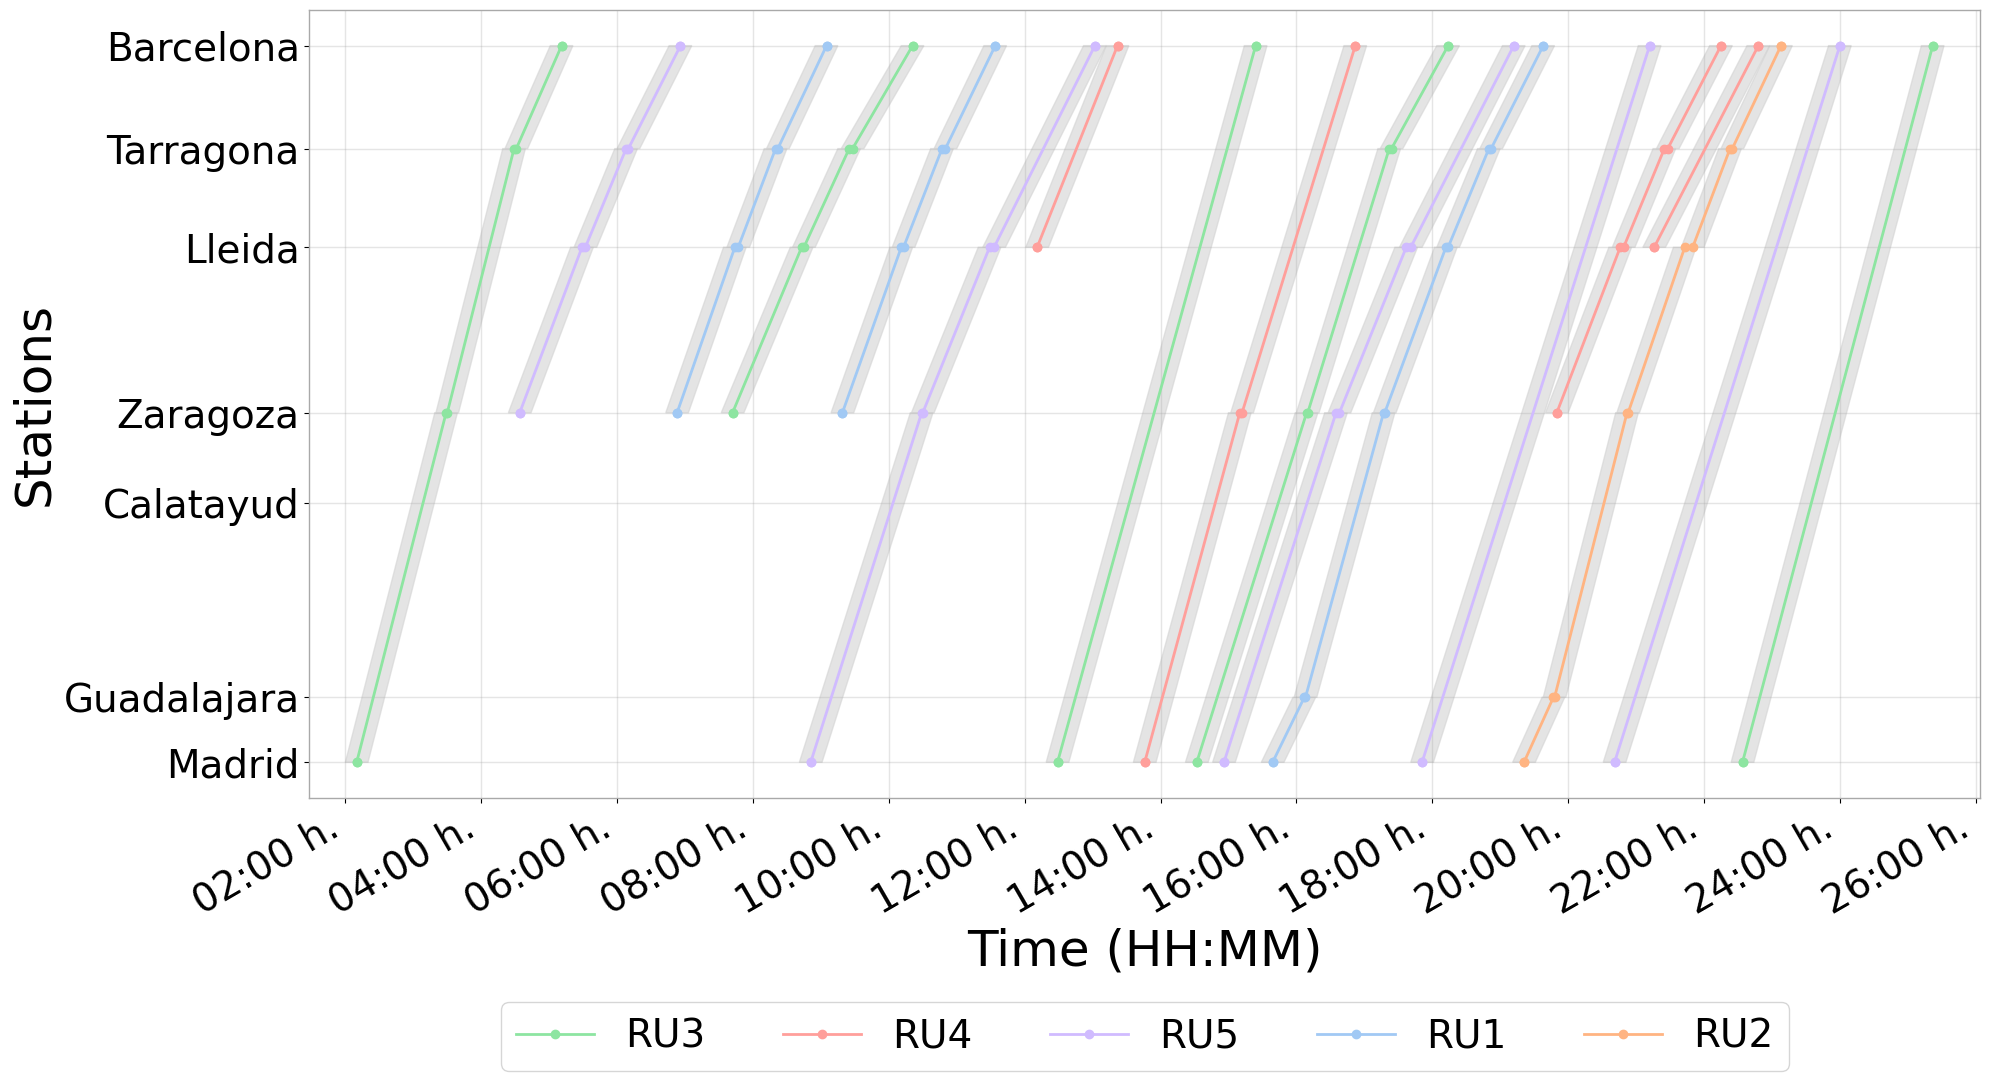

In [48]:
import datetime

date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()
plot_marey_chart(
    supply=final_supply,
    date=date,
    save_path='../figures/'
)

In [ ]:
#!snakeviz profile.pstat